## **Tutorial on Muller Brown Potential**
Our objective is to observe transutions between state A and B and calculate the free energy landscape.
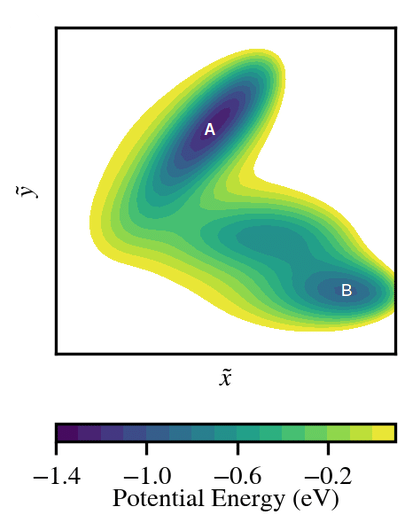

# Install Conda, Plumed, numpy etc.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!conda install numpy pandas
!conda install -c conda-forge plumed py-plumed

# Obtain tutorial files from github repo

In [ ]:
!rm -rf plumed_pytorch_tutorial
!git clone https://github.com/dhimanray/plumed_pytorch_tutorial.git

#Run unbiased simulation of Muller-Brown potential in state A

In [ ]:
path = 'plumed_pytorch_tutorial/mueller/'

##PES MD input file:
md_input = """
temperature 1.0
tstep 0.005
friction 10.0
dimension 2
nstep 200000
ipos -0.693111 1.40842
periodic false
"""
with open(path+'input', 'w') as file:
  file.write(md_input)

## PLUMED INPUT FILE FOR ENHANCED SAMPLING ##
plumed_input = """
UNITS NATURAL
p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ...
  ARG=p.x,p.y
  PERIODIC=NO
  FUNC=0.15*(-200*exp(-(x-1)^2-10*y^2)-100*exp(-x^2-10*(y-0.5)^2)-170*exp(-6.5*(0.5+x)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(1+x)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2)+146.7)
...
bb: BIASVALUE ARG=ff

xlwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
xuwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.0
ylwall: LOWER_WALLS ARG=p.y KAPPA=1000 AT=-0.2
yuwall: UPPER_WALLS ARG=p.y KAPPA=1000 AT=+2.0

newcv: MATHEVAL ARG=p.x,p.y PERIODIC=NO FUNC=x-y

#metad: METAD ARG=newcv PACE=100 HEIGHT=1.0 SIGMA=0.1 BIASFACTOR=10 TEMP=1.0

PRINT FMT=%g STRIDE=100 FILE=COLVAR_unbiased ARG=p.x,p.y

ENDPLUMED
"""

with open(path+'plumed.dat', 'w') as file:
  file.write(plumed_input)

!cd plumed_pytorch_tutorial/mueller && plumed pesmd < input

**Let's plot the data in x-y plane**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N = 200 #number of points for plotting/interpolation

m = 40   #number of contours

x, y, z = np.genfromtxt(r'plumed_pytorch_tutorial/mueller/2d_fes', unpack=True)

for i in range(len(z)):
    if z[i] >= 20.0:
        z[i] = 20
xi = np.linspace(x.min(), x.max(), N)
yi = np.linspace(y.min(), y.max(), N)
zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

X, Y = np.meshgrid(xi, yi)
plt.contour(X,Y,zi,colors='black', linewidths=1)

l = np.loadtxt('plumed_pytorch_tutorial/mueller/COLVAR_unbiased')

cp = plt.scatter(l[:,1],l[:,2],c='xkcd:lightblue')
#cbar = plt.colorbar(cp)
#cbar.set_label('metad.bias',fontsize=14)

plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)

The system is confined in state A and we do not see any transition to state B

# Metadynamics simulation
Now we will perform metadynamics to accelerate the transitions. This is done by using the METAD keyword of PLUMED. it takes the following arguments:

1. ARG: Collective Variable (we can use x, y, or any combination of them)
2. PACE: after how many step one gaussian hill is deposted
3. HEIGHT: Height of the gaussian hills
4. SIGMA: Width of the Gaussian Hills
5. BIASFACTOR: This parameter determines the extent of conformational exploration. Higher BIASFACTOR means higher exploration but slower convergence (test it!)

In [ ]:
path = 'plumed_pytorch_tutorial/mueller/'

##PES MD input file:
md_input = """
temperature 1.0
tstep 0.005
friction 10.0
dimension 2
nstep 200000
ipos -0.693111 1.40842
periodic false
"""
with open(path+'input', 'w') as file:
  file.write(md_input)

## PLUMED INPUT FILE FOR ENHANCED SAMPLING ##
plumed_input = """
UNITS NATURAL
p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ...
  ARG=p.x,p.y
  PERIODIC=NO
  FUNC=0.15*(-200*exp(-(x-1)^2-10*y^2)-100*exp(-x^2-10*(y-0.5)^2)-170*exp(-6.5*(0.5+x)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(1+x)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2)+146.7)
...
bb: BIASVALUE ARG=ff

xlwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
xuwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.0
ylwall: LOWER_WALLS ARG=p.y KAPPA=1000 AT=-0.2
yuwall: UPPER_WALLS ARG=p.y KAPPA=1000 AT=+2.0

newcv: MATHEVAL ARG=p.x,p.y PERIODIC=NO FUNC=x-y

metad: METAD ARG=p.y PACE=100 HEIGHT=1.0 SIGMA=0.1 BIASFACTOR=10 TEMP=1.0

PRINT FMT=%g STRIDE=100 FILE=COLVAR_metad ARG=p.x,p.y,metad.bias

ENDPLUMED
"""

with open(path+'plumed.dat', 'w') as file:
  file.write(plumed_input)

!cd plumed_pytorch_tutorial/mueller && plumed pesmd < input

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N = 200 #number of points for plotting/interpolation

m = 40   #number of contours

x, y, z = np.genfromtxt(r'plumed_pytorch_tutorial/mueller/2d_fes', unpack=True)

for i in range(len(z)):
    if z[i] >= 20.0:
        z[i] = 20
xi = np.linspace(x.min(), x.max(), N)
yi = np.linspace(y.min(), y.max(), N)
zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

X, Y = np.meshgrid(xi, yi)
plt.contour(X,Y,zi,colors='black', linewidths=1)

l1 = np.loadtxt('plumed_pytorch_tutorial/mueller/COLVAR_metad')

cp = plt.scatter(l1[:,1],l1[:,2],c='orange',alpha=1, label='Metadynamics')

l = np.loadtxt('plumed_pytorch_tutorial/mueller/COLVAR_unbiased')

plt.scatter(l[:,1],l[:,2],c='xkcd:lightblue', label='Unbiased')

plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
plt.legend(fontsize=12)

We see that metadynamics simulation leads to multiple transitions between states A and B. We will plot time vs. x and time vs. y to see these transitions

In [ ]:
l = np.loadtxt('plumed_pytorch_tutorial/mueller/COLVAR_metad')
cp = plt.scatter(l[:,0],l[:,1],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)
plt.xlabel('Simulation Time',fontsize=16)
plt.ylabel('x',fontsize=16)

In [ ]:
l = np.loadtxt('plumed_pytorch_tutorial/mueller/COLVAR_metad')
cp = plt.scatter(l[:,0],l[:,2],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)
plt.xlabel('Simulation Time',fontsize=16)
plt.ylabel('y',fontsize=16)

# Free Energy Estimations
Now we cal calculate the free energy along x and y anc compare that with the reference values provided.

In [ ]:
#Calculate 1D Free energy profile along x
!cd plumed_pytorch_tutorial/mueller && python FES_from_Reweighting.py --colvar COLVAR_metad --cv p.x --kt 1.0 --sigma 0.05 -o fes_x_test

fes_x_test = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_x_test')
fes_x_ref = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_x')

plt.plot(fes_x_test[:,0],fes_x_test[:,1],label='this work')
plt.plot(fes_x_ref[:,0],fes_x_ref[:,1],label='reference')
plt.xlabel('x',fontsize=16)
plt.ylabel('Free Energy ($k_B$T)',fontsize=16)
plt.legend(fontsize=12)

In [ ]:
#Calculate 1D Free energy profile along y axis
!cd plumed_pytorch_tutorial/mueller && python FES_from_Reweighting.py --colvar COLVAR_metad --cv p.y --kt 1.0 --sigma 0.05 -o fes_y_test

fes_y_test = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_y_test')
fes_y_ref = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_y')

plt.plot(fes_y_test[:,0],fes_y_test[:,1],label='this work')
plt.plot(fes_y_ref[:,0],fes_y_ref[:,1],label='reference')
plt.xlabel('y',fontsize=16)
plt.ylabel('Free Energy ($k_B$T)',fontsize=16)
plt.legend(fontsize=12)

**Now play with the Metadynamics paramteres like CV, gaussian height, bias-factor and see how the results change**